In [2]:
__author__ = 'Supriya'
#importing libraries for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import json
import math
import numpy as np
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3

from scipy.signal import lfilter

In [23]:
def splitAndConvert(value,splitter = ' '):
    return map(float,value)

def getRMSData(x,y,z):
    return [ math.sqrt((x[i]*x[i])+(y[i]*y[i])+(z[i]*z[i]))  for i in xrange(0,1024)]

def loadEvents():
	events = []
	with open('shock.json') as data_file:    
	    	for line in data_file:
			event = json.loads(line)
			event['x'] =  splitAndConvert(event['x']);
			event['y'] =  splitAndConvert(event['y']);
			event['z'] =  splitAndConvert(event['z']);
			event['rms'] = getRMSData(event['x'],event['y'],event['z'])
			events.append(event)
	return events

No of Events recorded : 1


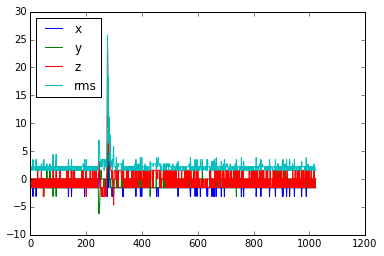

In [24]:
data = loadEvents()
print "No of Events recorded :", len(data) 
plt.plot (data[0]['x'], label="x")
plt.plot (data[0]['y'], label="y")
plt.plot (data[0]['z'], label="z")
plt.plot (data[0]['rms'],  label="rms")
plt.legend(loc='upper left')


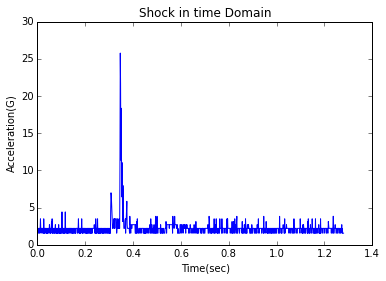

(1024, ' samples')
(800.0, ' samles/sec   ', 0.00125, ' sec')
 Enter the amplification factor (typically Q=10) 10
0.05
 Select algorithm: 
 1=Kelly-Richman  2=Smallwood 1
 Calculating response..... 
 Plotting output..... 


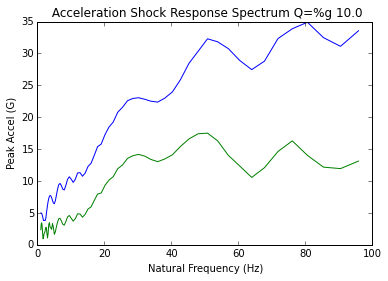

In [29]:
# iunit = input(' Enter acceleration unit:   1= G   2= m/sec^2  ')
iunit = 1
t = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]  # TIME VECTOR
y = [4.6875, 3.125, 25, -4.6875, 26.5625, 4.6875, -1.5625, 1.5625]  # ACCELERATION VECTOR
t = [float((1/800.0)* i) for i in xrange(1, 1025)]
y = data[0]['rms']
plt1.plot(t, y)
plt1.xlabel('Time(sec)')
plt1.ylabel('Acceleration(G)')
plt1.title('Shock in time Domain')
plt1.show()

tmx = max(t)
tmi = min(t)
n = len(y)
nnn = n
print(n, " samples")
dt = (tmx - tmi) / (n - 1)
sr = 1. / dt
print(sr, " samles/sec   ", dt, " sec")

fn = [0] * 800
# fn[0]=input(' Enter the starting frequency (Hz)  ')
fn[0] = 1  # Frequency 1Hz
if fn[0] > sr / 30.:
    fn[0] = sr / 30.

Q = input(' Enter the amplification factor (typically Q=10) ')
damp = 1. / (2. * Q)
print(damp)

print(' Select algorithm: ')
ialgorithm = input(' 1=Kelly-Richman  2=Smallwood ')

tmax = (tmx - tmi) + 1. / fn[0]

limit = int(round(tmax / dt))
n = limit
yy = [0] * limit
for i in range(len(y)):
    yy[i] = y[i]

print(' Calculating response..... ')

l = 0
while l < 800:
    if fn[l] > sr / 8.:
        break
    if l < 799:
        fn[l + 1] = fn[0] * pow(2., ((l + 1) * (1. / 12.)))
    l = l + 1

a1 = [0] * l
a2 = [0] * l
b1 = [0] * l
b2 = [0] * l
b3 = [0] * l

rd_a1 = [0] * l
rd_a2 = [0] * l
rd_b1 = [0] * l
rd_b2 = [0] * l
rd_b3 = [0] * l

x_neg = [0] * l
x_pos = [0] * l
x_std = [0] * l
rd_neg = [0] * l
rd_pos = [0] * l
pi = 3.1416

for j in range(l):

    omega = 2. * pi * fn[j]
    #print("omega", omega)
    omegad = omega * math.sqrt(1. - (pow(damp, 2)))
    #print(omegad)
    cosd = math.cos(omegad * dt)
    sind = math.sin(omegad * dt)
    domegadt = damp * omega * dt
    # rd_a1[j]=2.*math.exp(-domegadt)*cosd
    # rd_a2[j]=-math.exp(-2.*domegadt)
    # rd_b1[j]=0.
    # rd_b2[j]=-(dt/omegad)*math.exp(-domegadt)*sind
    # rd_b3[j]=0

    if ialgorithm == 1:
        a1[j] = 2. * math.exp(-domegadt) * cosd
        a2[j] = -math.exp(-2. * domegadt)
        b1[j] = 2. * domegadt
        b2[j] = omega * dt * math.exp(-domegadt)
        b2[j] *= (omega / omegad) * (1. - 2. * (pow(damp, 2))) * sind - 2. * damp * cosd
        b3[j] = 0

    else:
        E = math.exp(-damp * omega * dt)
        K = omegad * dt
        C = E * math.cos(K)
        S = E * math.sin(K)
        Sp = S / K
        a1[j] = 2 * C
        a2[j] = -(pow(E, 2))
        b1[j] = 1. - Sp
        b2[j] = 2. * (Sp - C)
        b3[j] = pow(E, 2) - Sp

    forward = [b1[j], b2[j], b3[j]]
    back = [1, -a1[j], -a2[j]]

    resp = lfilter(forward, back, yy)
    x_pos[j] = max(resp)
    x_neg[j] = min(resp)
    x_std[j] = np.std(resp)

    rd_forward = [rd_b1[j], rd_b2[j], rd_b3[j]]
    rd_back = [1, -rd_a1[j], -rd_a2[j]]

    rd_resp = lfilter(rd_forward, rd_back, yy)

    rd_pos[j] = max(rd_resp)
    rd_neg[j] = min(rd_resp)

    # Relative Displacement

    jnum = j
    # if  fn[j] > sr/8.:
    #     break
    # if j<799:
    #     fn[j+1]=fn[1]*pow(2.,(j*(1./12.)))

tmax = (tmx - tmi)

print(' Plotting output..... ')

#  Find limits for plot

srs_max = max(x_pos)
if max(abs(i) for i in x_neg) > srs_max:
    srs_max = max(abs(i) for i in x_neg)

maximaxSRS = srs_max

srs_min = min(x_pos)
if min(abs(i) for i in x_neg) < srs_min:
    srs_min = min(abs(i) for i in x_neg)

Q = 1. / (2. * damp);
out5 = ' Acceleration Shock Response Spectrum Q=%g ' + str(Q)
#print(out5)

ymax = math.pow(10, (int(round(np.log10(srs_max) + 0.8))))
ymin = math.pow(10, (int(round(np.log10(srs_min) - 0.6))))

fmax = max(fn);
fmin = fmax / 10.;

fmax = math.pow(10, (int(round(np.log10(fmax) + 0.5))))

fmin = 0.1

x_neg_abs = [0] * len(x_neg)
for i in range(len(x_neg)):
    x_neg_abs[i] = abs(x_neg[i])

fn1 = [0] * l
for i in range(l):
    fn1[i] = fn[i]

# fn1 = np.array(fn)
# x_pos1 =np.array(x_pos)
# x_neg_abs1 =np.array(x_neg_abs)

plt2.plot(fn1, x_pos, fn1, x_neg_abs)
plt2.title(out5)
plt2.xlabel('Natural Frequency (Hz)')
plt2.ylabel('Peak Accel (G)')
# plt2.axis([fmin, fmax, ymin, ymax])
plt2.show()